In [1]:
%matplotlib inline
import numpy as np
import sys
sys.path.append('./utils/')
from sklearn.utils.extmath import *
from sklearn.utils.extmath import randomized_svd
import adaptoctree.morton as morton
import adaptoctree.tree as tree
import fmm.surface as surface
from scripts.precompute_operators import rsvd
from fmm.kernel import laplace_gram_matrix_serial
import matplotlib.pyplot as plt
from functions_from_matlab import krylov_schur_svd

# Matrix Creation

In [2]:
def compress_m2l_gram_matrix(
        dense_gram_matrix, level, x0, r0, depth, alpha_inner, check_surface,
        equivalent_surface, k, dtype
    ):
    """
    Compute compressed representation of unique Gram matrices for targets and
    sources at a given level of the octree, specified by their unique transfer
    vectors. Compression is computed using the randomised-SVD of Halko et. al.
    (2011).

    Parameters:
    -----------
    dense_gram_matrix: function
        Gram matrix function handle.
    level : int
        Octree level at which M2L operators are being calculated.
    x0 : np.array(shape=(1, 3), dtype=np.float64)
        Center of octree root node.
    r0 : np.float64
	    Half side length of octree root node.
    alpha_inner : float
        Relative size of inner surface.
    check_surface : np.array(shape=(ncheck_points, 3), dtype=float)
        Discretized check surface.
    equivalent_surface : np.array(shape=(nequivalent_points, 3), dtype=float)
        Discretized equivalent surface.
    k : int
        Target compression rank.

    Returns:
    --------
    (
        np.array(shape=(nu, k), float),
        np.array(shape=(ns), dtype=float),
        np.array(shape=(k, nvt), dtype=float),
        np.array(shape=(316), dtype=int)
    )
        Tuple of SVD components of aggregated M2L matrix at this level, as well
        as hashes of the transfer vectors to index the components by.
    """
    sources, targets, hashes = tree.find_unique_v_list_interactions(
        level=level, x0=x0, r0=r0, depth=depth
    )

    n_targets_per_node = len(check_surface)
    n_sources_per_node = len(equivalent_surface)
    n_sources = len(sources)

    # Create a collated equivalent to check surface for sources/targets
    # corresponding to unique transfer vectors at this level.
    se2tc = np.zeros((n_targets_per_node, n_sources*n_sources_per_node), dtype)

    for idx in range(len(targets)):

        target = targets[idx]
        source = sources[idx]

        target_center = morton.find_physical_center_from_key(
            key=target,
            x0=x0,
            r0=r0
        )

        source_center = morton.find_physical_center_from_key(
            key=source,
            x0=x0,
            r0=r0
        )

        lidx_sources = idx*n_sources_per_node
        ridx_sources = lidx_sources+n_sources_per_node

        target_check_surface = surface.scale_surface(
            surf=check_surface,
            radius=r0,
            level=level,
            center=target_center,
            alpha=alpha_inner
        )

        source_equivalent_surface = surface.scale_surface(
            surf=equivalent_surface,
            radius=r0,
            level=level,
            center=source_center,
            alpha=alpha_inner
        )

        se2tc[:, lidx_sources:ridx_sources] =  dense_gram_matrix(
                sources=source_equivalent_surface, targets=target_check_surface
            )

    return se2tc
    # Run RSVD compression.
    # u, s, vt = rsvd(se2tc, k)

    # return u, s, vt, hashes

In [3]:
order_equivalent = 15
order_check = 10
dtype = np.float32
equivalent_surface = surface.compute_surface(order_equivalent, dtype)
check_surface = surface.compute_surface(order_check, dtype)

In [4]:
equivalent_surface.shape

(1178, 3)

In [5]:
154208/316

488.0

In [6]:
check_surface.shape

(488, 3)

In [7]:
x0 = np.array([0., 0., 0.])
r0 = 0.5
alpha_inner = 1.05
alpha_outer = 1.95
k = 10
level = 2
depth = 3

In [8]:
se2tc = compress_m2l_gram_matrix(laplace_gram_matrix_serial, level, x0, r0, depth, alpha_inner, check_surface, equivalent_surface, k, dtype)

In [9]:
se2tc.shape

(488, 372248)

# 1) SVD

u, s, vt = np.linalg.svd(se2tc.T)

plt.plot(s)

s

# 2) Randomized SVD

In [10]:

#u, s, v = randomized_svd(se2tc.T,n_components = 7, power_iteration_normalizer = 'QR')
u, s, v = randomized_svd(se2tc.T,n_components = 7)

$$$$
(372248, 17)
(372248, 488)
****
(488, 17)
(488, 372248)
****
$$$$
$$$$
(372248, 17)
(372248, 488)
****
(488, 17)
(488, 372248)
****
$$$$
$$$$
(372248, 17)
(372248, 488)
****
(488, 17)
(488, 372248)
****
$$$$
$$$$
(372248, 17)
(372248, 488)
****
(488, 17)
(488, 372248)
****
$$$$
$$$$
(372248, 17)
(372248, 488)
****
(488, 17)
(488, 372248)
****
$$$$
$$$$
(372248, 17)
(372248, 488)
****
(488, 17)
(488, 372248)
****
$$$$
$$$$
(372248, 17)
(372248, 488)
****
(488, 17)
(488, 372248)
****
$$$$
14


In [11]:
s

array([1342.7596  ,  112.55628 ,  112.55621 ,  112.55593 ,   22.379822,
         22.379805,   22.379791], dtype=float32)

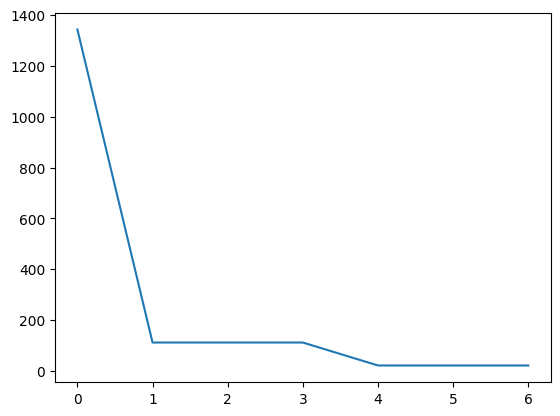

In [12]:
plt.plot(s)

In [13]:
u.shape

(372248, 7)

In [14]:
v.shape

(7, 488)

# 3) Krylov Schur

In [15]:
se2tc.T.shape

(372248, 488)

In [16]:
sigma, V, U, hist, mvs, counter = krylov_schur_svd(se2tc, nr= 7,tol = 1e-6)

ATA
4.5490639209747314
0.0013997554779052734
4.67426872253418
0.07488322257995605
ATAE
2.677431583404541
0.004141330718994141
3.2127461433410645
0.09863042831420898
0: 5.995825894173188e-07
40
Found after 1 iteration(s) with residual = 5.995825894173188e-07


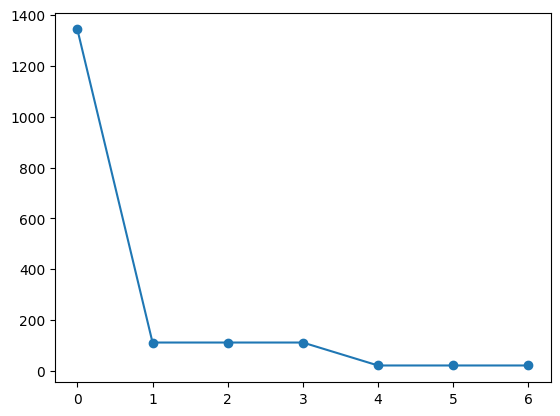

In [17]:
plt.plot(sigma,marker = 'o')

In [18]:
V.shape

(372248, 7)

In [19]:
U.shape

(488, 7)

# Benchmarks of Matrix

In [20]:
# Matrix with col vec
v1 = np.random.randn(se2tc.shape[1])
se2tc.dot(v1);

In [21]:
# Matrix with col vec
v1 = np.random.randn(se2tc.shape[1])
se2tc @ v1;

In [22]:
# Matrix.T with col vec
v1 = np.random.randn(se2tc.shape[0])
(se2tc.T).dot(v1);

In [23]:
# Matrix.T with col vec
v1 = np.random.randn(se2tc.shape[0])
se2tc.T @ v1;

In [24]:
vec = np.random.randn(se2tc.shape[0],17)
se2tc.T @ vec;

# Comparing Results of RSVD and Krylov Schur

In [25]:
#Relative Error
np.abs(s - sigma)/max(max(np.abs(s)),max(np.abs(sigma)))

array([4.000028126007942e-07, 6.518978713801453e-08,
       1.419100106436260e-08, 1.956869508869990e-07,
       1.850124918649249e-09, 1.084163012987403e-08,
       2.077150815330129e-08])

In [26]:
rel_s = s/np.linalg.norm(s)
rel_sigma = sigma/np.linalg.norm(sigma)

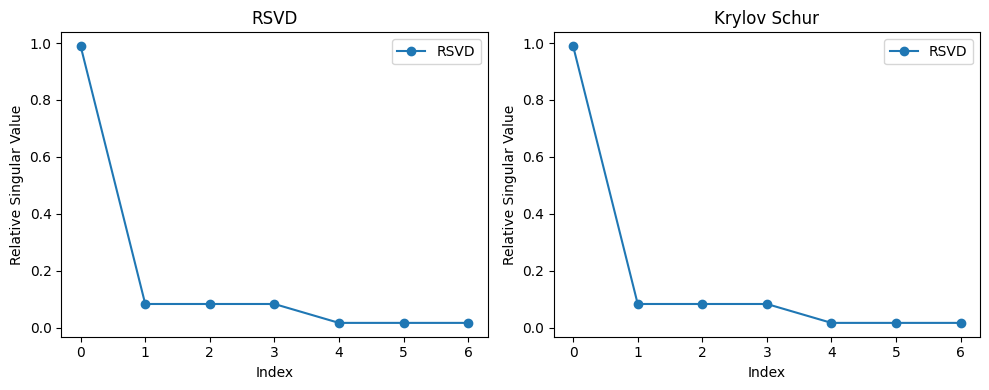

In [27]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot data on the first subplot
ax1.plot(rel_s, label='RSVD', marker = 'o')
ax1.set_title('RSVD')
ax1.set_xlabel('Index')
ax1.set_ylabel('Relative Singular Value')
ax1.legend()

# Plot data on the second subplot
ax2.plot(rel_sigma, label='RSVD', marker = 'o')
ax2.set_title('Krylov Schur')
ax2.set_xlabel('Index')
ax2.set_ylabel('Relative Singular Value')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Matrix MATLAB File Upload

In [28]:
from scipy.io import savemat

In [29]:
a = se2tc.T
mdic = {"a": a, "label": "experiment"}

In [30]:
folder_path = '/Users/chamundeshwarivadamalai/Desktop/MLF/MATLAB_Timo/ks_svd/'
file_name = 'matlab_matrix.mat'
full_path = folder_path + file_name

In [31]:
savemat(full_path, mdic)

# Massive Test

In [10]:
from sklearn.utils.extmath import randomized_range_finder

In [11]:
(se2tc.T).shape

(372248, 488)

In [12]:
matr = randomized_range_finder(A = se2tc.T,size = 17 , n_iter = 7,power_iteration_normalizer="auto",
    random_state=None)

$$$$
Q:(372248, 17)
A:(372248, 488)
****1
Q:(488, 17)
A.T:(488, 372248)
****2
$$$$
$$$$
Q:(372248, 17)
A:(372248, 488)
****1
Q:(488, 17)
A.T:(488, 372248)
****2
$$$$
$$$$
Q:(372248, 17)
A:(372248, 488)
****1
Q:(488, 17)
A.T:(488, 372248)
****2
$$$$
$$$$
Q:(372248, 17)
A:(372248, 488)
****1
Q:(488, 17)
A.T:(488, 372248)
****2
$$$$
$$$$
Q:(372248, 17)
A:(372248, 488)
****1
Q:(488, 17)
A.T:(488, 372248)
****2
$$$$
$$$$
Q:(372248, 17)
A:(372248, 488)
****1
Q:(488, 17)
A.T:(488, 372248)
****2
$$$$
$$$$
Q:(372248, 17)
A:(372248, 488)
****1
Q:(488, 17)
A.T:(488, 372248)
****2
$$$$
mvs:14


In [35]:
matr.shape

(372248, 17)

In [36]:
x = matr.T @ se2tc.T

In [37]:
x.shape

(17, 488)

In [38]:
sigmat, Vt, Ut, histt, mvst, countert = krylov_schur_svd(x , nr= 7,tol = 1e-6)

ATA
0.00015163421630859375
8.678436279296875e-05
0.0006465911865234375
0.0002446174621582031
ATAE
9.870529174804688e-05
8.368492126464844e-05
0.00010466575622558594
0.00011897087097167969
0: 2.8490306656652315e-27
40
Found after 1 iteration(s) with residual = 2.8490306656652315e-27


In [39]:
sigmat

array([1342.7595046911515  ,  112.55662236742714 ,  112.55610707343975 ,
        112.55599936715113 ,   22.379830695410288,   22.379824560472404,
         22.379800069583535])

In [40]:
sigma

array([1342.7601806625364  ,  112.55619450920668 ,  112.5561943237951  ,
        112.55619385195412 ,   22.37981929306968 ,   22.379819168915287,
         22.379819150919666])

In [41]:
#Relative Error
np.abs(sigmat - sigma)/max(max(np.abs(sigmat)),max(np.abs(sigma)))

array([5.034192960460680e-07, 3.186408314929878e-07,
       6.497836069763420e-08, 1.448395668788562e-07,
       8.491717859905800e-09, 4.015279269412569e-09,
       1.421053171333673e-08])

In [42]:
#Relative Error
np.abs(s - sigma)/max(max(np.abs(s)),max(np.abs(sigma)))

array([4.000028126007942e-07, 6.518978713801453e-08,
       1.419100106436260e-08, 1.956869508869990e-07,
       1.850124918649249e-09, 1.084163012987403e-08,
       2.077150815330129e-08])